# PulseAI: Maternal Health Risk Prediction - Model Training

This notebook documents the end-to-end process of building and evaluating the machine learning model for the PulseAI project. The goal is to predict the risk level of maternal health complications based on vital signs and other patient data.

We will perform the following steps:
1.  **Data Loading and Exploration**: Understand the dataset's structure and characteristics.
2.  **Exploratory Data Analysis (EDA)**: Visualize data distributions and relationships.
3.  **Data Preprocessing**: Prepare the data for training by encoding, splitting, and scaling.
4.  **Model Training and Comparison**: Train multiple classification algorithms to find the best performer.
5.  **Hyperparameter Tuning**: Optimize the best model to enhance its predictive accuracy and recall.
6.  **Final Evaluation and Conclusion**: Assess the final model and justify its selection.

In [2]:
%pip install pandas numpy matplotlib seaborn scikit-learn imblearn xgboost

  Using cached pandas-2.3.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.7-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.7.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
  Using cached xgboost-3.1.1-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached imbalanced_learn-0.14.0-py3-none-any.whl.metadata (8.8 kB)
Using cached pandas-2.3.3-cp312-cp312-win_amd64.whl (11.0 MB)
Using cached matplotlib-3.10.7-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached scikit_learn-1.7.2-cp312-cp312-win_amd64.whl (8.7 MB)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
Using cached xgboost-3.1.1-py3-none-win_amd64.whl (72.0 MB)
Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl (2


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1. Setup and Data Loading

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
from imblearn.over_sampling import SMOTE

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Set visualization style
sns.set_style("whitegrid")

In [4]:
# Load the dataset
try:
    df = pd.read_csv('maternal_health_risk.csv')
    print("Dataset loaded successfully!")
    df.head()
except FileNotFoundError:
    print("Error: 'Maternal-Health-Risk-Data-Set.csv' not found.")
    print("Please ensure the dataset file is in the same directory as this notebook.")

Dataset loaded successfully!


### 2. Exploratory Data Analysis (EDA)

Now, let's explore the dataset to understand its structure, identify any missing data, and visualize the relationships between different features.

In [5]:
# Get a concise summary of the dataframe
print("Dataset Information:")
df.info()

print("\n" + "="*50 + "\n")

# Check for missing values
print("Missing Values per Column:")
print(df.isnull().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


Missing Values per Column:
Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


In [6]:
# Generate descriptive statistics
print("Descriptive Statistics:")
df.describe()

Descriptive Statistics:


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


#### Visualize Target Variable Distribution

Let's see how the different risk levels are distributed in the dataset. This helps us understand if the dataset is balanced or if one class is more frequent than others.

C:\Users\acer\AppData\Local\Temp\ipykernel_22552\765234704.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RiskLevel', data=df, palette='viridis')


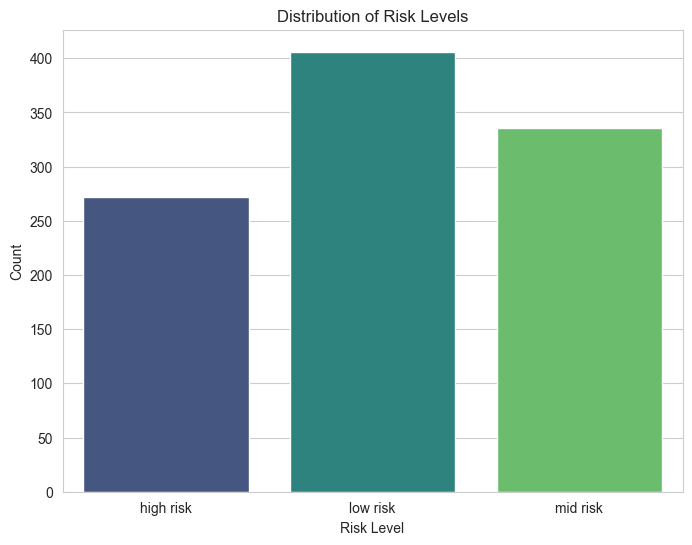

In [7]:
# Plot the distribution of the 'RiskLevel' target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='RiskLevel', data=df, palette='viridis')
plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.show()

#### Visualize Feature Distributions

Histograms are a great way to visualize the distribution of each numerical feature. This can help us spot outliers or skewed data.

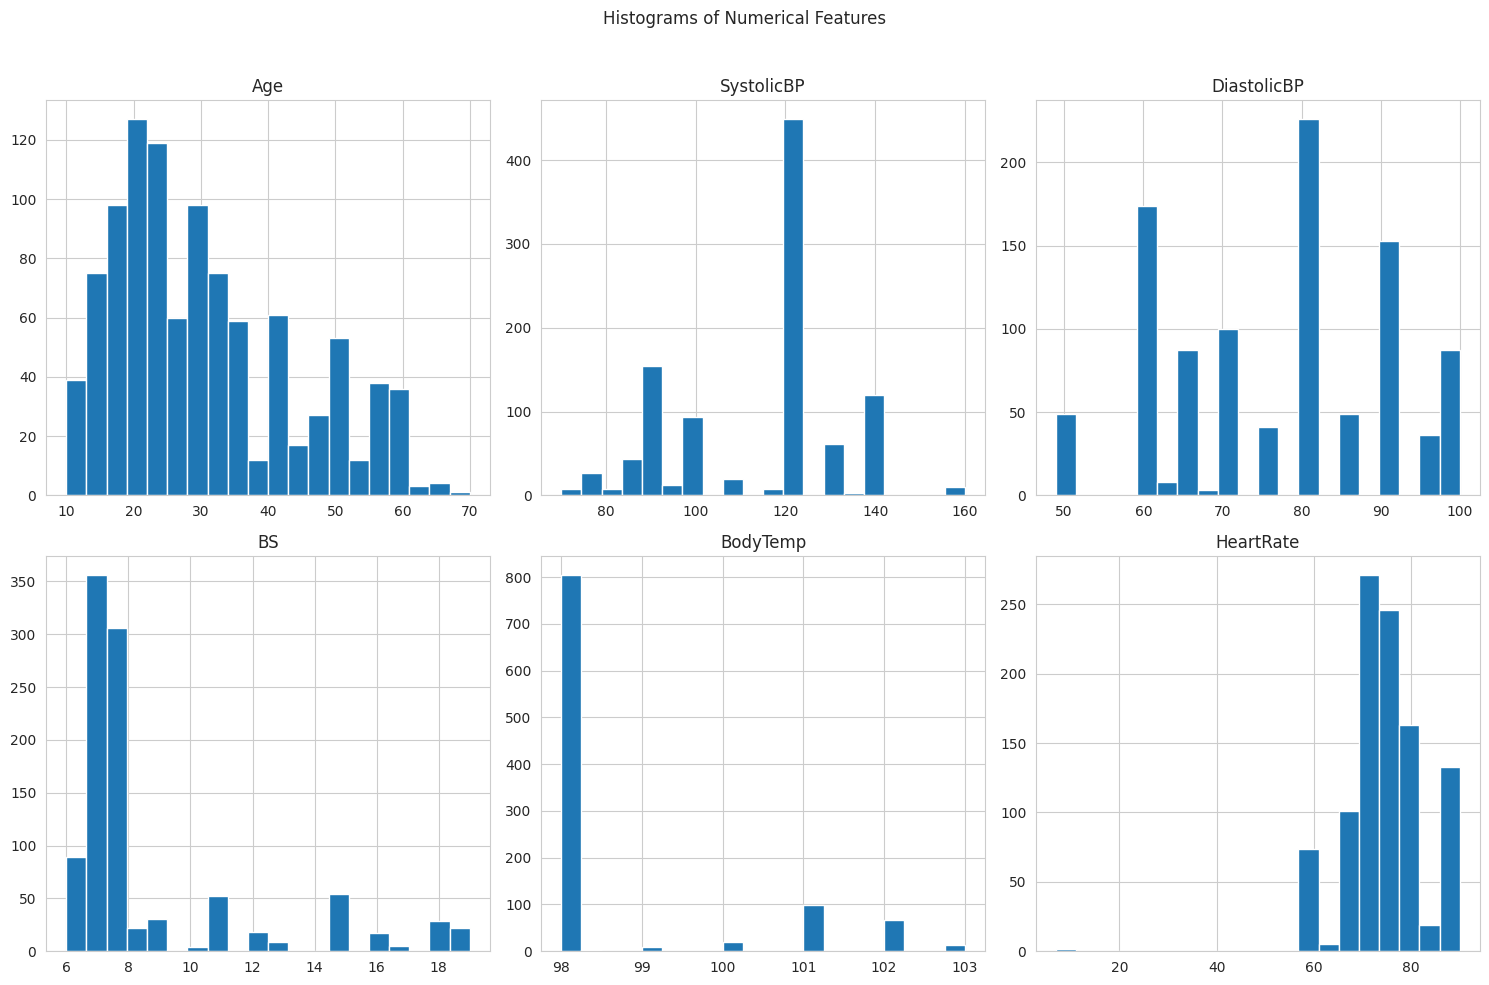

In [7]:
# Plot histograms for all numerical features
df.hist(bins=20, figsize=(15, 10), layout=(2, 3))
plt.suptitle('Histograms of Numerical Features')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 3. Data Preprocessing

In [8]:
# Define features (X) and target (y)
from imblearn.over_sampling import SMOTE

X = df.drop('RiskLevel', axis=1)
y = df['RiskLevel']

# Encode the target variable to numerical format
# We will map {'low risk': 1, 'mid risk': 2, 'high risk': 0} to align with the project's convention
risk_mapping = {'high risk': 0, 'low risk': 1, 'mid risk': 2}
y_encoded = y.map(risk_mapping)
target_names = ['high risk', 'low risk', 'mid risk']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to handle class imbalance on the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set shape: {X_train.shape}")
print(f"Resampled training set shape: {X_train_resampled.shape}")
print(f"Class distribution after SMOTE: \n{pd.Series(y_train_resampled).value_counts()}")

Original training set shape: (811, 6)
Resampled training set shape: (975, 6)
Class distribution after SMOTE: 
RiskLevel
0    325
1    325
2    325
Name: count, dtype: int64


### 4. Model Training and Comparison

--- Logistic Regression ---
Accuracy: 0.6059
High-Risk Recall: 0.8000
              precision    recall  f1-score   support

   high risk       0.75      0.80      0.77        55
    low risk       0.61      0.70      0.65        81
    mid risk       0.44      0.33      0.38        67

    accuracy                           0.61       203
   macro avg       0.60      0.61      0.60       203
weighted avg       0.59      0.61      0.59       203



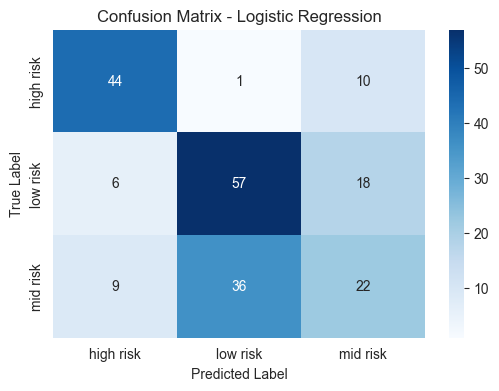


--- Decision Tree ---
Accuracy: 0.8424
High-Risk Recall: 0.8909
              precision    recall  f1-score   support

   high risk       0.96      0.89      0.92        55
    low risk       0.91      0.78      0.84        81
    mid risk       0.71      0.88      0.79        67

    accuracy                           0.84       203
   macro avg       0.86      0.85      0.85       203
weighted avg       0.86      0.84      0.85       203



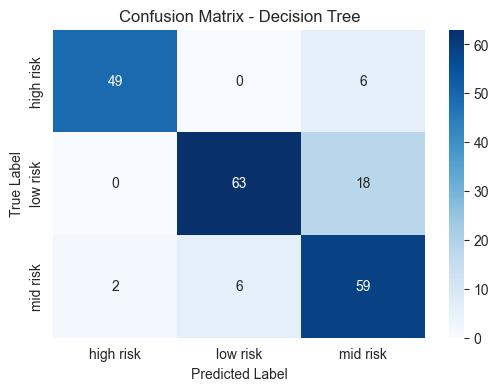


--- Random Forest ---
Accuracy: 0.8621
High-Risk Recall: 0.9273
              precision    recall  f1-score   support

   high risk       0.98      0.93      0.95        55
    low risk       0.89      0.81      0.85        81
    mid risk       0.75      0.87      0.81        67

    accuracy                           0.86       203
   macro avg       0.88      0.87      0.87       203
weighted avg       0.87      0.86      0.86       203

--- Random Forest ---
Accuracy: 0.8621
High-Risk Recall: 0.9273
              precision    recall  f1-score   support

   high risk       0.98      0.93      0.95        55
    low risk       0.89      0.81      0.85        81
    mid risk       0.75      0.87      0.81        67

    accuracy                           0.86       203
   macro avg       0.88      0.87      0.87       203
weighted avg       0.87      0.86      0.86       203



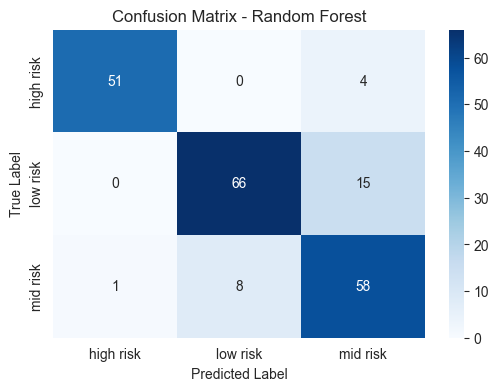


--- Gradient Boosting ---
Accuracy: 0.7931
High-Risk Recall: 0.8727
              precision    recall  f1-score   support

   high risk       0.96      0.87      0.91        55
    low risk       0.79      0.77      0.78        81
    mid risk       0.68      0.76      0.72        67

    accuracy                           0.79       203
   macro avg       0.81      0.80      0.80       203
weighted avg       0.80      0.79      0.80       203

--- Gradient Boosting ---
Accuracy: 0.7931
High-Risk Recall: 0.8727
              precision    recall  f1-score   support

   high risk       0.96      0.87      0.91        55
    low risk       0.79      0.77      0.78        81
    mid risk       0.68      0.76      0.72        67

    accuracy                           0.79       203
   macro avg       0.81      0.80      0.80       203
weighted avg       0.80      0.79      0.80       203



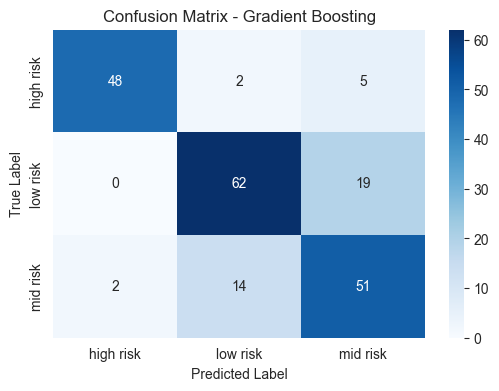


--- Support Vector Machine ---
Accuracy: 0.7192
High-Risk Recall: 0.8909
              precision    recall  f1-score   support

   high risk       0.94      0.89      0.92        55
    low risk       0.63      0.86      0.73        81
    mid risk       0.68      0.40      0.50        67

    accuracy                           0.72       203
   macro avg       0.75      0.72      0.72       203
weighted avg       0.73      0.72      0.71       203

--- Support Vector Machine ---
Accuracy: 0.7192
High-Risk Recall: 0.8909
              precision    recall  f1-score   support

   high risk       0.94      0.89      0.92        55
    low risk       0.63      0.86      0.73        81
    mid risk       0.68      0.40      0.50        67

    accuracy                           0.72       203
   macro avg       0.75      0.72      0.72       203
weighted avg       0.73      0.72      0.71       203



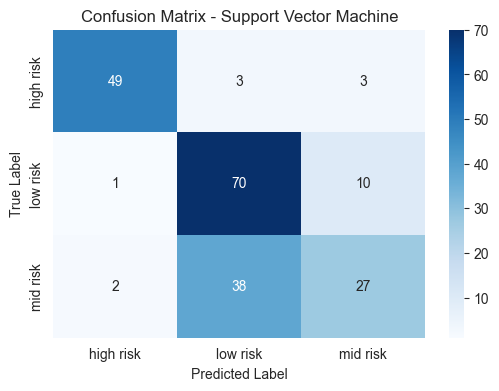


--- AdaBoost ---
Accuracy: 0.6995
High-Risk Recall: 0.8727
              precision    recall  f1-score   support

   high risk       0.87      0.87      0.87        55
    low risk       0.66      0.78      0.71        81
    mid risk       0.60      0.46      0.52        67

    accuracy                           0.70       203
   macro avg       0.71      0.70      0.70       203
weighted avg       0.70      0.70      0.69       203



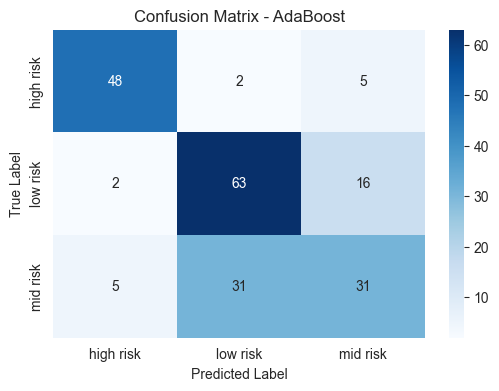

c:\Users\acer\Desktop\ML_temp\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:43:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost ---
Accuracy: 0.8571
High-Risk Recall: 0.9091
              precision    recall  f1-score   support

   high risk       0.93      0.91      0.92        55
    low risk       0.92      0.80      0.86        81
    mid risk       0.76      0.88      0.81        67

    accuracy                           0.86       203
   macro avg       0.87      0.86      0.86       203
weighted avg       0.87      0.86      0.86       203



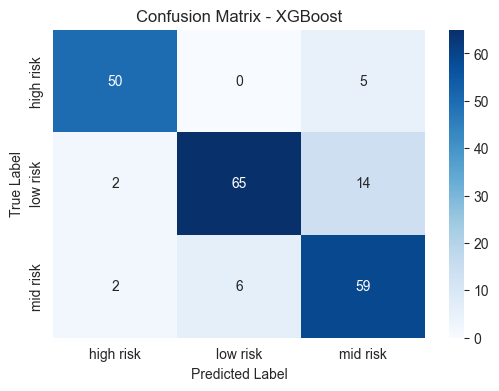

,Accuracy,High-Risk Recall,High-Risk Precision,High-Risk F1
Model,,,,
Logistic Regression,0.605911,0.800000,0.745763,0.771930
Decision Tree,0.842365,0.890909,0.960784,0.924528
Random Forest,0.862069,0.927273,0.980769,0.953271
Gradient Boosting,0.793103,0.872727,0.960000,0.914286
Support Vector Machine,0.719212,0.890909,0.942308,0.915888
AdaBoost,0.699507,0.872727,0.872727,0.872727
XGBoost,0.857143,0.909091,0.925926,0.917431


In [9]:
# Define the models to be trained
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

results = []

for name, model in models.items():
    # Train on SMOTE-resampled data to handle class imbalance
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    high_risk_recall = recall_score(y_test, y_pred, labels=[0], average='macro')
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    high_risk_precision = report['high risk']['precision']
    high_risk_f1 = report['high risk']['f1-score']

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "High-Risk Recall": high_risk_recall,
        "High-Risk Precision": high_risk_precision,
        "High-Risk F1": high_risk_f1
    })

    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"High-Risk Recall: {high_risk_recall:.4f}")
    print(classification_report(y_test, y_pred, target_names=target_names))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print("=" * 60 + "\n")

results_df = pd.DataFrame(results).set_index("Model")
results_df

#### Feature Importance

#### Classification Report

#### Confusion Matrix for the Best Performing Model (Gradient Boosting)

### 6. Hyperparameter Tuning for Gradient Boosting

### 7. Final Model Evaluation

#### Final Classification Report

#### Final Confusion Matrix

#### Evaluate the Tuned Model on the Test Set

#### Final Classification Report

#### Final Confusion Matrix

#### Evaluate the Tuned Model on the Test Set

#### Feature Importance

#### Classification Report

#### Confusion Matrix for the Best Performing Model (Gradient Boosting)

#### Compare Model Performance

#### Scale Numerical Features

#### Split Data into Training and Testing Sets

#### Encode Categorical Target Variable

#### Correlation Matrix

# IOT based Health Monitoring System using Different types of Machine Learning Algorithm.

# Package Importing

# Dataset Reading

# Data PreProcessing

# Data Visualization

# Model Implementation

#  Naive Bayes Algorithm

# Classification report and Confusion matrix of Naive Bayes Algorithm

# Decision Tree Algorithm

# Classification report and Confusion matrix of Decision Tree Algorithm

# Logistic Regression Algorithm

# Classification report and Confusion matrix of Logistic Regression Algorithm

# Support Vector Machine Algorithm

In [ ]:
from sklearn.svm import SVC
SVM_Algorithm = SVC()
SVM_Algorithm.fit(x_train1, y_train1)
SVM_Algorithm_Prediction = SVM_Algorithm.predict(x_test1)
Accuracy_SVM = accuracy_score(y_test1, LR_Algorithm_Prediction)
print('Accuracy of Support Vector Machine Algorithm', Accuracy_SVM)

Accuracy of Support Vector Machine Algorithm 0.5333333333333333


In [ ]:
SVM_Algorithm_Prediction

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 2, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0], dtype=int64)

# Classification report and Confusion matrix of Support Vector Machine Algorithm

              precision    recall  f1-score   support

           0       0.29      0.56      0.38         9
           1       0.50      0.55      0.52        11
           2       0.00      0.00      0.00        10

    accuracy                           0.37        30
   macro avg       0.26      0.37      0.30        30
weighted avg       0.27      0.37      0.31        30



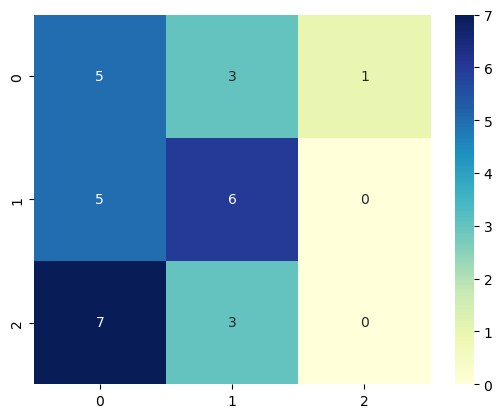

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
CM_SVM=confusion_matrix(y_test1, SVM_Algorithm_Prediction)
sns.heatmap(CM_SVM, annot=True, fmt='d', cmap='YlGnBu')
print(classification_report(y_test1, SVM_Algorithm_Prediction))

# Comparison Plot of all the Graph

Text(0.5, 1.0, 'Comparison Graph of all the Algorithm')

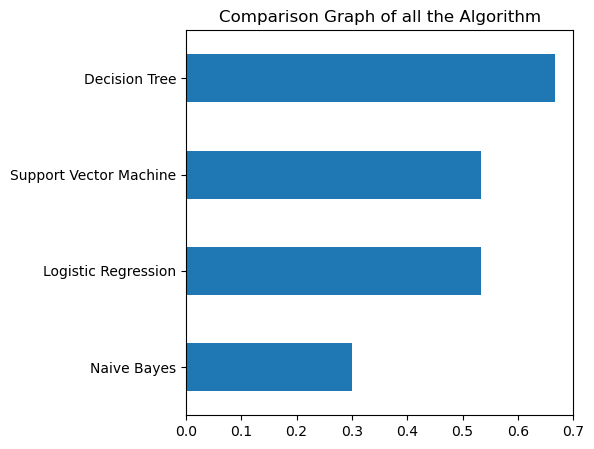

In [ ]:
model_accuracy = pd.Series(data=[Accuracy_NB,Accuracy_DT,Accuracy_LR,Accuracy_SVM],
                index=['Naive Bayes','Decision Tree','Logistic Regression','Support Vector Machine'])
fig= plt.figure(figsize=(5,5))
model_accuracy.sort_values().plot.barh()
plt.title('Comparison Graph of all the Algorithm')

# Final Prediction Model

In [ ]:
Final_Prediction_data = (71,1,32,0,77)
Final_Prediction_data = np.array(Final_Prediction_data)
Final_Prediction_data = Final_Prediction_data.reshape(1,-1)
Final_prediction = DT_Algorithm.predict(Final_Prediction_data)

if Final_prediction == 0:
    print("The Patient Condition is Low")
elif Final_prediction == 1:
    print("The Patient Condition is Medium")
else:
    print("The Patient Condition is High")

This Patient Condition is High


In [ ]:
Final_Prediction_data = (10,2,32,0,77)
Final_Prediction_data = np.array(Final_Prediction_data)
Final_Prediction_data = Final_Prediction_data.reshape(1,-1)
Final_prediction = DT_Algorithm.predict(Final_Prediction_data)

if Final_prediction == 0:
    print("The Patient Condition is Low")
elif Final_prediction == 1:
    print("The Patient Condition is Medium")
else:
    print("The Patient Condition is High")

The Patient Condition is Medium


In [ ]:
Final_Prediction_data = (43,1,32,0,77)
Final_Prediction_data = np.array(Final_Prediction_data)
Final_Prediction_data = Final_Prediction_data.reshape(1,-1)
Final_prediction = DT_Algorithm.predict(Final_Prediction_data)

if Final_prediction == 0:
    print("The Patient Condition is Low")
elif Final_prediction == 1:
    print("The Patient Condition is Medium")
else:
    print("The Patient Condition is High")

The Patient Condition is High
